#  1、线性回归的从零开始实现

在了解线性回归的关键思想之后，我们可以开始通过代码来动⼿实现线性回归了。在这⼀节中，我们将从零
开始实现整个⽅法，包括数据流⽔线、模型、损失函数和⼩批量随机梯度下降优化器。虽然现代的深度学习
框架⼏乎可以⾃动化地进⾏所有这些⼯作，但从零开始实现可以确保我们真正知道⾃⼰在做什么。同时，了
解更细致的⼯作原理将⽅便我们⾃定义模型、⾃定义层或⾃定义损失函数。在这⼀节中，我们将只使⽤张量
和⾃动求导。在之后的章节中，我们会充分利⽤深度学习框架的优势，介绍更简洁的实现⽅式。

In [32]:
%matplotlib inline
import random
import torch
from d2l import torch as d2l

## 1.1 生成数据集

在下⾯的代码中，我们
⽣成⼀个包含1000个样本的数据集，每个样本包含从标准正态分布中采样的2个特征。我们的合成数据集是
⼀个矩阵

In [33]:
def synthetic_data(w,b,num_examples):
    """
    生成y = Xw+b的噪声
    w：全中向量
    b:偏置向量
    num_examples:样本数量
    """
    X = torch.normal(0,1,(num_examples,len(w)))
    """
    torch.normal(mean, std, size)：这个函数用于生成符合正态分布的随机数，其中：
    
        mean：正态分布的均值。在这个例子中，均值是 0，表示分布以零为中心。

        std：正态分布的标准差。在这个例子中，标准差是 1
        表示是标准正态分布（通常称为“标准高斯分布”）。

        size：要生成的张量的形状，用一个元组表示。
        在这个例子中，形状是 (num_examples, len(w))，
        这意味着生成的张量有 num_examples 行和 len(w) 列。
    """
    y = torch.matmul(X,w)+b
    y += torch.normal(0,0.01,y.shape)
    return X, y.reshape((-1,1)) # -1 表示这一维度的大小由 PyTorch 自动计算

In [34]:
true_w = torch.tensor([2,-3.4])
true_b = 4.2
features, labels = synthetic_data(true_w,true_b,1000)
# features,labels

In [35]:
print('features:',features[0],'\nlabel:',labels[0])

features: tensor([-0.0908,  0.9156]) 
label: tensor([0.9140])


注意，features中的每⼀⾏都包含⼀个⼆维数据样本，labels中的每⼀⾏都包含⼀维标签值（⼀个标量）。

通过⽣成第⼆个特征features[:, 1]和labels的散点图，可以直观观察到两者之间的线性关系。


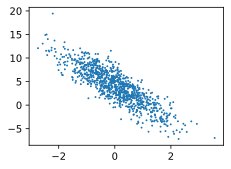

In [36]:
d2l.set_figsize()
d2l.plt.scatter(features[:, 1].detach().numpy(), labels.detach().numpy(), 1)

##  1.2 读取数据集

训练模型时要对数据集进⾏遍历，每次抽取⼀⼩批量样本，并使⽤它们来更新我们的模型。由于
这个过程是训练机器学习算法的基础，所以有必要定义⼀个函数，该函数能打乱数据集中的样本并以⼩批量
⽅式获取数据。

在下⾯的代码中，我们定义⼀个**data_iter**函数，该函数接收批量⼤⼩、特征矩阵和标签向量作为输⼊，⽣成
⼤⼩为**batch_size**的⼩批量。每个⼩批量包含⼀组特征和标签。

In [37]:
def data_iter(batch_size, features, labels):
    num_examples = len(features)
    indices = list(range(num_examples))
    # 这些样本是随机读取的，没有特定的顺序
    random.shuffle(indices)
    for i in range(0, num_examples, batch_size):
        batch_indices = torch.tensor(
            indices[i: min(i + batch_size, num_examples)])
        yield features[batch_indices], labels[batch_indices]

这个函数 `data_iter` 用于实现小批量随机梯度下降（mini-batch stochastic gradient descent，SGD）中的数据迭代器。它从给定的数据集中随机抽取小批量样本。以下是代码的详细解释：

### 函数参数

- `batch_size`: 每个小批量中的样本数。
- `features`: 输入特征的张量。
- `labels`: 输入特征对应的标签张量。

### 函数步骤

1. **计算样本总数**:
   ```python
   num_examples = len(features)
   ```
   计算数据集中样本的总数。

2. **生成样本索引**:
   ```python
   indices = list(range(num_examples))
   ```
   创建一个包含从 `0` 到 `num_examples - 1` 的索引列表，用于表示每个样本的位置。

3. **随机打乱索引**:
   ```python
   random.shuffle(indices)
   ```
   随机打乱样本索引，使得数据以无特定顺序进行抽取。这有助于提高训练模型的泛化能力。

4. **批量迭代**:
   ```python
   for i in range(0, num_examples, batch_size):
       batch_indices = torch.tensor(
           indices[i: min(i + batch_size, num_examples)])
       yield features[batch_indices], labels[batch_indices]
   ```
   - 这个循环从数据集中提取小批量样本。
   - `range(0, num_examples, batch_size)` 控制从数据集中每次取 `batch_size` 个样本。
   - `indices[i: min(i + batch_size, num_examples)]` 计算当前批次的索引范围。
   - `torch.tensor(...)` 将当前批次的索引转换为 PyTorch 张量。
   - `yield` 用于返回一个生成器对象，每次迭代时返回当前批次的 `features` 和 `labels`。

### 作用

该函数的主要作用是生成一个随机的批量数据集，使得在训练过程中可以使用这些小批量数据进行模型参数更新。通过随机抽取样本，可以更好地避免过拟合并提高训练的效率和效果。

In [38]:
batch_size = 10
for X, y in data_iter(batch_size, features, labels):
    print(X, '\n', y)
    break

tensor([[ 0.8128,  0.3129],
        [ 1.3496, -0.7478],
        [ 0.4394, -1.0207],
        [-1.3110,  1.4257],
        [-0.8344, -0.4760],
        [-0.8083, -0.3774],
        [-0.5650,  0.4442],
        [ 0.2872, -0.0405],
        [ 1.2745, -2.4295],
        [ 0.0322, -0.4545]]) 
 tensor([[ 4.7585],
        [ 9.4447],
        [ 8.5483],
        [-3.2756],
        [ 4.1514],
        [ 3.8580],
        [ 1.5732],
        [ 4.9242],
        [14.9946],
        [ 5.8255]])


## 1 .3 初始化模型参数

在我们开始⽤⼩批量随机梯度下降优化我们的模型参数之前，我们需要先有⼀些参数。在下⾯的代码中，我
们通过从均值为0、标准差为0.01的正态分布中采样随机数来初始化权重，并将偏置初始化为0。



In [39]:
w = torch.normal(0,0.01,size=(2,1),requires_grad=True)
b = torch.zeros(1,requires_grad=True)
# required_grad 代表是否算梯度

##  1.4 定义模型

In [40]:
def linreg(X,w,b):
    return torch.matmul(X,w) + b

## 1.5 定义损失函数

In [41]:
def squared_loss(y_hat, y):
    # 均方损失
    return ((y_hat - y.reshape(y_hat.shape)) ** 2) / 2

这段代码定义了一个计算均方误差（Mean Squared Error, MSE）的函数 `squared_loss`，用于评估预测值 `y_hat` 与真实值 `y` 之间的误差。以下是该代码的详细解释：

### 函数说明

```python
def squared_loss(y_hat, y):
    # 均方损失
    return ((y_hat - y.reshape(y_hat.shape)) ** 2) / 2
```

### 参数

- **`y_hat`**: 模型预测值，通常是通过神经网络或者其他模型进行前向传播得到的输出。
  
- **`y`**: 真实值，即目标标签。

### 功能解释

1. **重塑真实值**:
   - `y.reshape(y_hat.shape)`: 将 `y` 重新调整为与 `y_hat` 相同的形状。
   - 这一步是必要的，因为在计算损失时，预测值和真实值必须具有相同的形状，以便进行逐元素操作。

2. **计算平方误差**:
   - `(y_hat - y.reshape(y_hat.shape)) ** 2`: 计算每个预测值和真实值之间的平方误差。
   - 通过平方差值，可以得到每个元素的误差平方，强调大误差。

3. **除以 2**:
   - `/ 2`: 将每个平方误差除以 2。
   - 这种形式是均方误差的一种变体，常用于梯度下降等优化算法中，因为它的导数形式（即梯度）更为简洁。

### 作用

- **损失计算**: 均方误差用于评估模型预测值和真实值之间的差异，值越小表示模型预测越准确。

- **训练优化**: 在机器学习模型训练中，优化算法（如梯度下降）通过最小化损失函数值来调整模型参数，使模型预测更加准确。

### 应用场景

- **回归问题**: 均方误差广泛应用于回归问题中，用于衡量模型的预测效果。

- **神经网络**: 在训练神经网络时，均方误差可以用作损失函数，以指导模型的参数更新。

## 1.6 定义优化算符

In [42]:
def sgd(params, lr, batch_size): #@save
    """⼩批量随机梯度下降"""
    with torch.no_grad():
        for param in params:
            param -= lr * param.grad / batch_size
            param.grad.zero_()

这个函数 `sgd` 实现了小批量随机梯度下降（Stochastic Gradient Descent, SGD）算法，用于更新模型的参数。以下是对这段代码的详细解释：

### 参数

- **`params`**: 可训练的模型参数列表（如权重和偏置）。这些参数需要包含梯度信息，因为我们将使用这些梯度来更新参数。

- **`lr`**: 学习率（learning rate），用于控制参数更新的步长。较大的学习率会导致更新幅度较大，而较小的学习率则更新较为缓慢。

- **`batch_size`**: 小批量的样本数量，用于对梯度进行平均，以便更稳定地更新参数。

### 功能解释

1. **`with torch.no_grad():`**:
   - 这个上下文管理器禁用梯度计算。
   - 在更新参数时，我们不需要计算梯度，因此使用 `no_grad` 可以提高计算效率，并防止 PyTorch 的自动求导机制记录不必要的计算历史。

2. **参数更新**:
   - `for param in params:`：迭代所有可训练参数。
   - `param -= lr * param.grad / batch_size`：更新每个参数。
     - `param.grad` 是对应参数的梯度。
     - `lr * param.grad / batch_size` 计算更新的步长。因为梯度是基于批量计算的，所以我们将它除以 `batch_size`，这相当于对梯度进行平均。
     - `param -= ...` 用更新后的值减去步长，更新参数。
  
3. **梯度清零**:
   - `param.grad.zero_()`：将参数的梯度清零。
   - 在每个训练步骤后清零梯度是必要的，以防止在下一次迭代时累积上一次迭代的梯度。

### 作用

- **参数更新**: 通过使用当前计算的梯度更新模型参数，SGD 逐步最小化损失函数。

- **训练效率**: 使用小批量样本而非整个数据集来计算梯度，使得 SGD 更高效，尤其在大规模数据集上。

- **避免过拟合**: 由于每次更新基于不同的小批量样本，SGD 具有天然的正则化效果，可以帮助模型更好地泛化。

### 使用场景

- **机器学习模型训练**: 在训练深度学习模型时，SGD 是一种常用的优化算法，尤其是在处理大规模数据时。

- **在线学习**: 由于 SGD 的更新是逐步的，它也适用于流式数据的在线学习场景。

##  1.7 训练

In [43]:
lr = 0.03
num_epochs = 3
net = linreg
loss = squared_loss


In [44]:
for epoch in range(num_epochs):
    for X,y in data_iter(batch_size,features,labels):
        l = loss(net(X,w,b),y)
        l.sum().backward()
        sgd([w,b],lr,batch_size)
    with torch.no_grad():
        train_l = loss(net(features,w,b),labels)
        print(f'epoch {epoch + 1}, loss {float(train_l.mean()):f}')

epoch 1, loss 0.055550
epoch 2, loss 0.000257
epoch 3, loss 0.000050


In [45]:
print(f'w的估计误差: {true_w - w.reshape(true_w.shape)}')
print(f'b的估计误差: {true_b - b}')


w的估计误差: tensor([ 0.0008, -0.0004], grad_fn=<SubBackward0>)
b的估计误差: tensor([0.0011], grad_fn=<RsubBackward1>)


In [46]:
true_w,w

(tensor([ 2.0000, -3.4000]),
 tensor([[ 1.9992],
         [-3.3996]], requires_grad=True))

In [47]:
true_b,b

(4.2, tensor([4.1989], requires_grad=True))